In [2]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

### Metadata

##### Occupation Data:

- **Total Rows**: 1,020,802
- **Missing Values**: Around 1%, present in the `state_name` column

    <br>

    | Column Name                | Description |
    |-----------------------------|-------------|
    | FIPS                        | FIPS code for the county |
    | State_GEOID                 | Same as the FIPS for the State |
    | naics                       | NAICS code for the industry |
    | NAICS_TITLE                 | NAICS titel for the industry |
    | emp_total_county_naics      | Total of all employees in a county for a NAICS code |
    | OCC_CODE                    | SOC occupation code |
    | OCC_TITLE                   | SOC occupation description |
    | emp_occupation              | Number of employees in the occupation |
    | state_name                  | Name of the state |


### Loading data

In [5]:
# Get the current working directory
current_folder = os.getcwd()

# Move up one folder
project_folder = os.path.abspath(os.path.join(current_folder, '..', '..'))

# Read the data from the pickle files
data_path = project_folder + "/data/raw/"

# Occupation data
occupation_data_1 = pd.read_pickle(data_path + "naics_occupation_part1.pickle")
occupation_data_2 = pd.read_pickle(data_path + "naics_occupation_part2.pickle")
occupation_data_3 = pd.read_pickle(data_path + "naics_occupation_part3.pickle")
occupation_data = pd.concat([occupation_data_1, occupation_data_2, occupation_data_3])

# Read the ranking data
ranking_industries = pd.read_excel(data_path + "ranking_industries.xlsx")
ranking_occupations = pd.read_excel(data_path + "ranking_occupations.xlsx")

### Preperation

In [ ]:
# Convert the data types
occupation_data["naics"] = occupation_data["naics"].astype(str)
occupation_data["OCC_CODE"] = occupation_data["OCC_CODE"].astype(str)
occupation_data["emp_occupation"] = occupation_data["emp_occupation"].astype(int)

ranking_industries["naics"] = ranking_industries["naics"].astype(str)
ranking_occupations["OCC_CODE"] = ranking_occupations["OCC_CODE"].astype(str)

In [ ]:
# Group the data by the occupation code, count all fips codes and sum the employment data
occupation_data_overall = occupation_data.groupby(["OCC_CODE", "OCC_TITLE"]).agg({"FIPS": "count", "emp_occupation": "sum"}).reset_index()
occupation_data_overall = occupation_data_overall.rename(columns={"FIPS": "fips_count", "emp_occupation": "emp_occupation_sum"})

# Group the data by naics code and then by occupation code, count all fips codes and sum the employment data
occupation_data_by_industry = occupation_data.groupby(["naics", "NAICS_TITLE", "OCC_CODE", "OCC_TITLE"]).agg({"FIPS": "count", "emp_total_county_naics": "sum", "emp_occupation": "sum"}).reset_index()
occupation_data_by_industry = occupation_data_by_industry.rename(columns={"FIPS": "fips_count", "emp_total_county_naics": "emp_total_county_naics_sum", "emp_occupation": "emp_occupation_sum"})

In [ ]:
# Join the overall occupation data with the ranking data
occupation_data_overall = occupation_data_overall.merge(ranking_occupations, on="OCC_CODE", how="left")

# Join the occupation data by industry with the ranking data
occupation_data_by_industry = occupation_data_by_industry.merge(ranking_occupations, on="OCC_CODE", how="left")
occupation_data_by_industry = occupation_data_by_industry.merge(ranking_industries, on="naics", how="left")

In [ ]:
# Based on the manual scoring, well drop the rows where: TODO: 0.5
    # Industry score is =< 0.33
    # Occupation score is =< 0.33

occupation_data_overall = occupation_data_overall[(occupation_data_overall["occupation_score"] > 0.33)]

occupation_data_by_industry = occupation_data_by_industry[(occupation_data_by_industry["industry_score"] > 0.33) 
                                  & (occupation_data_by_industry["occupation_score"] > 0.33)]

### Feature Selection

- Score of Industry --> [industry_score]
- Score of Occupation --> [occupation_score]
- Total of all employees (in a county) by industry --> [emp_total_county_naics_sum]
- Total of all employees (in a county) by industry and occupaton --> [emp_occupation_sum]

### Ranking

In [ ]:
# Define weights for each rank
weights = {
    "fips_count_rank": 1.0,
    "industry_rank": 1.0,
    "occupation_rank": 1.0,
    "emp_industry_rank": 1.0,
    "emp_occupation_rank": 1.0
}

In [ ]:
# Create ranking per feature for overall occupation data
occupation_data_overall["fips_count_rank"] = occupation_data_overall["fips_count"].rank(method="dense", ascending=False).astype(int)
occupation_data_overall["occupation_rank"] = occupation_data_overall["occupation_score"].rank(method="dense", ascending=False).astype(int)
occupation_data_overall["emp_occupation_rank"] = occupation_data_overall["emp_occupation_sum"].rank(method="dense", ascending=False).astype(int)

# Calculate the weighted mean for all ranks in the occupation data by industry
occupation_data_overall["overall_rank"] = (
    occupation_data_overall["fips_count_rank"] * weights["fips_count_rank"] +
    occupation_data_overall["occupation_rank"] * weights["occupation_rank"] + 
    occupation_data_overall["emp_occupation_rank"] * weights["emp_occupation_rank"]
) / sum(weights.values()) #TODO weigths 

# Sort the dataframe and display the top 10 occupations
occupation_data_overall = occupation_data_overall.sort_values("overall_rank")
top_ten_occupations = occupation_data_overall.head(10) #TODO dynamisch maken

display(top_ten_occupations[["OCC_TITLE", "fips_count_rank" , "occupation_rank", "emp_occupation_rank", "overall_rank"]])


,OCC_TITLE,fips_count_rank,occupation_rank,emp_occupation_rank,overall_rank
61,"Welders, Cutters, Solderers, and Brazers",2,2,2,1.2
39,"Maintenance and Repair Workers, General",1,5,1,1.4
52,Machinists,6,3,3,2.4
36,Industrial Machinery Mechanics,4,3,5,2.4
28,Automotive Service Technicians and Mechanics,8,5,4,3.4
29,Bus and Truck Mechanics and Diesel Engine Spec...,5,5,12,4.4
15,Sheet Metal Workers,10,4,9,4.6
47,"Cutting, Punching, and Press Machine Setters, ...",14,6,6,5.2
31,"Mobile Heavy Equipment Mechanics, Except Engines",7,4,17,5.6
43,Structural Metal Fabricators and Fitters,9,4,18,6.2


In [ ]:
# Convert the top then OCC_CODE to a list
top_ten_occupations_list = top_ten_occupations["OCC_CODE"].tolist()

# Filter the data for the top occupations
filtered_data = occupation_data[occupation_data["OCC_CODE"].isin(top_ten_occupations_list)]

# Pivot table to restructure the data: Rows = FIPS, Columns = OCC_CODE, Values = Sum of emp_occupation
pivoted_df = filtered_data.pivot_table(
    index="FIPS", 
    columns="OCC_CODE", 
    values="emp_occupation", 
    aggfunc="sum",  # Summing values for each FIPS and OCC_CODE
    fill_value=0    # Replace NaN with 0
).reset_index()

# Rename columns for clarity if needed
pivoted_df.columns.name = None  # Remove the pivot column grouping name
pivoted_df.rename(columns={occ_code: str(occ_code) for occ_code in top_ten_occupations_list}, inplace=True)

# sort by combined sum of all occupation employment columns
pivoted_df["total_sum"] = pivoted_df.iloc[:, 1:].sum(axis=1)

# Sort the DataFrame based on the total_sum column in descending order
pivoted_df = pivoted_df.sort_values(by="total_sum", ascending=False)
pivoted_df

,FIPS,47-2211,49-3023,49-3031,49-3042,49-9041,49-9071,51-2041,51-4031,51-4041,51-4121,total_sum
2531,48201,1784,4621,2567,2279,9905,8192,1611,2507,4429,12037,49932
384,12999,1029,1335,837,388,2632,21143,691,1093,3316,4428,36892
204,06037,2007,6316,1740,671,3457,6867,600,1775,6844,5532,35809
597,17031,1519,4743,1139,227,1581,6579,830,3999,5471,4009,30097
102,04013,1885,4087,1191,1503,1499,5585,546,1108,3281,3755,24440
...,...,...,...,...,...,...,...,...,...,...,...,...
2125,40127,0,0,0,0,0,0,0,0,0,0,0
1012,21087,0,0,0,0,0,0,0,0,0,0,0
2132,40141,0,0,0,0,0,0,0,0,0,0,0
1747,35033,0,0,0,0,0,0,0,0,0,0,0


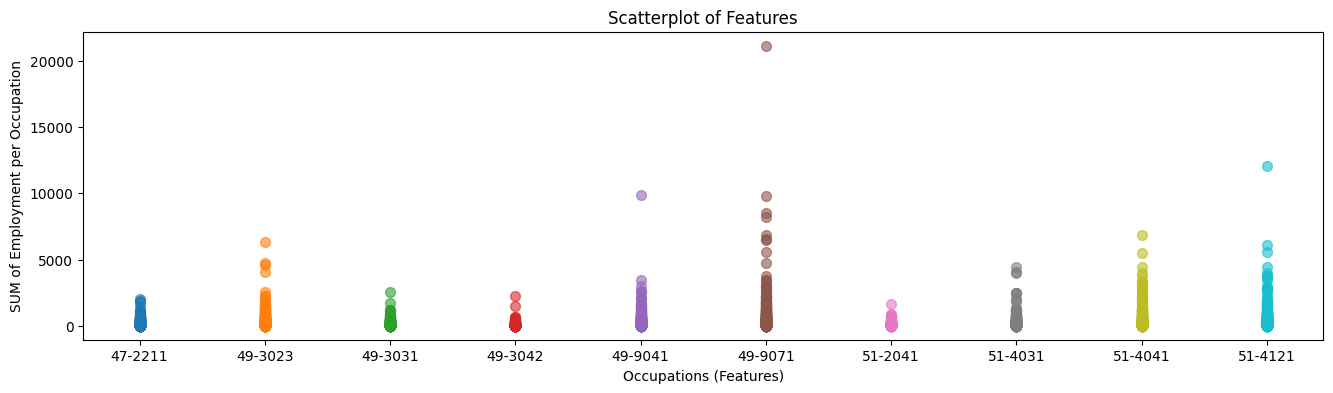

In [ ]:
# Drop 'FIPS' column
pivoted_df_no_fips = pivoted_df.drop(columns=["FIPS", "total_sum"])

plt.figure(figsize=(16,4))

# Plot points without NaN values for each column except 'FIPS'
for col in pivoted_df_no_fips.columns:
    # Remove NaN values
    non_nan_data = pivoted_df_no_fips[col].dropna()
    plt.scatter([col] * len(non_nan_data), non_nan_data, s=50, alpha=0.6, label=col)  # Set s to a fixed value

plt.xlabel("Occupations (Features)")
plt.ylabel("SUM of Employment per Occupation")
plt.title("Scatterplot of Features")
plt.show()

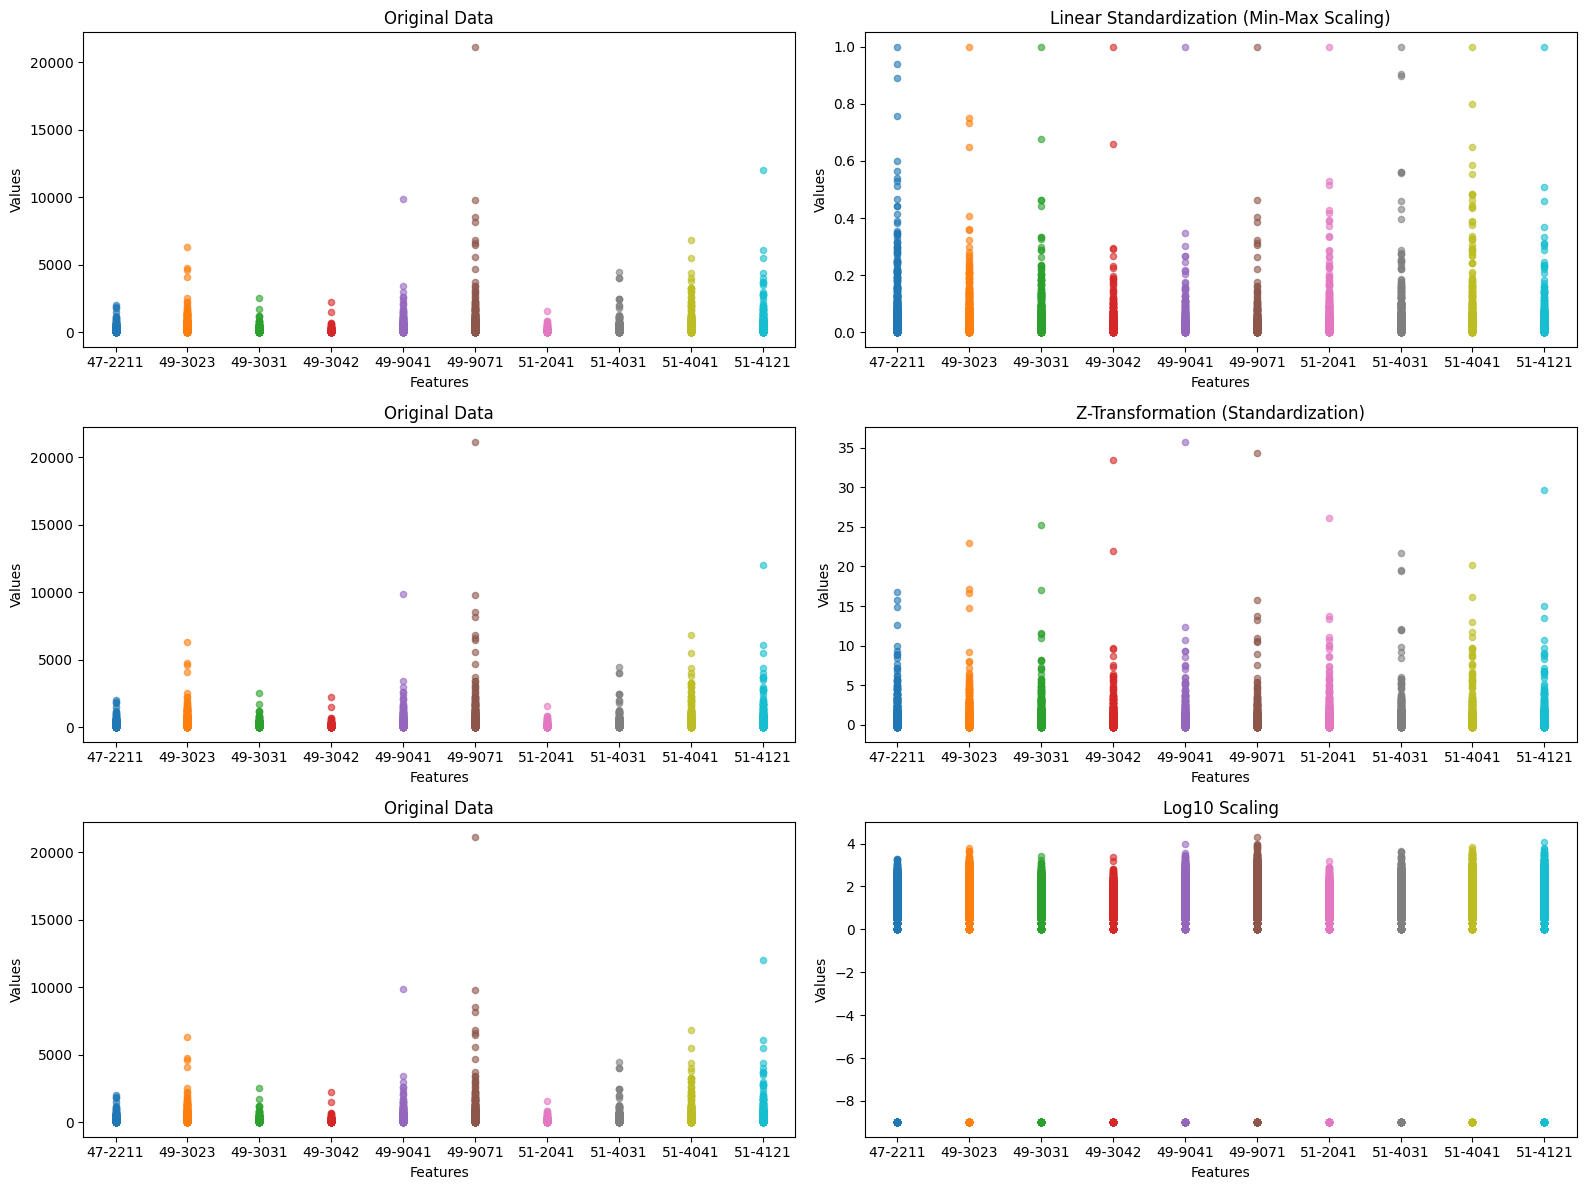

In [ ]:
# Drop the 'FIPS' column
pivoted_df_no_fips = pivoted_df.drop(columns=["FIPS", "total_sum"])

# Linear Standardization (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
feature_df_minmax = scaler_minmax.fit_transform(pivoted_df_no_fips)

# Z-transformation (Standardization)
scaler_standard = StandardScaler()
feature_df_zscore = scaler_standard.fit_transform(pivoted_df_no_fips)

# Log10 Scaling (with a small constant to avoid log(0))
feature_df_log10 = np.log10(pivoted_df_no_fips + 1e-9)

# Plotting function with automatic y-limits adjustment
def plot_features(data, title, ax):
    for i, col in enumerate(pivoted_df_no_fips.columns):
        non_nan_data = data[:, i][~np.isnan(data[:, i])]  # Get non-NaN data for each feature
        ax.scatter([col] * len(non_nan_data), non_nan_data, s=20, alpha=0.6, label=col)
    ax.set_xlabel("Features")
    ax.set_ylabel("Values")
    ax.set_title(title)
       

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharey=False)

# List of data pairs and titles for each subplot
data_pairs = [
    (pivoted_df_no_fips.to_numpy(), "Original Data", feature_df_minmax, "Linear Standardization (Min-Max Scaling)"),
    (pivoted_df_no_fips.to_numpy(), "Original Data", feature_df_zscore, "Z-Transformation (Standardization)"),
    (pivoted_df_no_fips.to_numpy(), "Original Data", feature_df_log10.to_numpy(), "Log10 Scaling")
]

# Plot each pair of datasets in the grid
for row, (original_data, original_title, transformed_data, transformed_title) in enumerate(data_pairs):
    # Plot original data in the left column
    plot_features(original_data, original_title, axes[row, 0])
    # Plot transformed data in the right column
    plot_features(transformed_data, transformed_title, axes[row, 1])

# Adjust layout and show legend for each subplot
plt.tight_layout()
plt.show()

### Additional part, where occupation is split up by industry

In [ ]:
# Stop mark to end execution
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

c:\Users\lenna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Create ranking per feature for occupation data by industry
occupation_data_by_industry["fips_count_rank"] = occupation_data_by_industry["fips_count"].rank(method="dense", ascending=False).astype(int)
occupation_data_by_industry["industry_rank"] = occupation_data_by_industry["industry_score"].rank(method="dense", ascending=False).astype(int)
occupation_data_by_industry["occupation_rank"] = occupation_data_by_industry["occupation_score"].rank(method="dense", ascending=False).astype(int)
occupation_data_by_industry["emp_industry_rank"] = occupation_data_by_industry["emp_total_county_naics_sum"].rank(method="dense", ascending=False).astype(int)
occupation_data_by_industry["emp_occupation_rank"] = occupation_data_by_industry["emp_occupation_sum"].rank(method="dense", ascending=False).astype(int)

# Calculate the weighted mean for all ranks in the occupation data by industry
occupation_data_by_industry["overall_rank"] = (
    occupation_data_by_industry["fips_count_rank"] * weights["fips_count_rank"] +
    occupation_data_by_industry["industry_rank"] * weights["industry_rank"] +
    occupation_data_by_industry["occupation_rank"] * weights["occupation_rank"] +
    occupation_data_by_industry["emp_industry_rank"] * weights["emp_industry_rank"] +
    occupation_data_by_industry["emp_occupation_rank"] * weights["emp_occupation_rank"]
) / sum(weights.values())

# Sort the dataframe and display the top 10 occupations by industry 
occupation_data_by_industry = occupation_data_by_industry.sort_values("overall_rank")
top_ten_occupations_by_industry = occupation_data_by_industry.head(10)

display(top_ten_occupations_by_industry[["NAICS_TITLE", "OCC_TITLE", "fips_count_rank", "industry_rank", "occupation_rank", "emp_industry_rank", "emp_occupation_rank", "overall_rank"]])

,NAICS_TITLE,OCC_TITLE,fips_count_rank,industry_rank,occupation_rank,emp_industry_rank,emp_occupation_rank,overall_rank
259,Building Equipment Contractors,Sheet Metal Workers,1,5,4,1,6,3.4
1584,Automotive Repair and Maintenance,Automotive Body and Related Repairers,5,3,2,25,2,7.4
1585,Automotive Repair and Maintenance,Automotive Service Technicians and Mechanics,5,3,5,25,1,7.8
1586,Automotive Repair and Maintenance,Bus and Truck Mechanics and Diesel Engine Spec...,5,3,5,25,9,9.4
1577,Services to Buildings and Dwellings,"Maintenance and Repair Workers, General",12,7,5,14,12,10.0
268,Building Equipment Contractors,"Maintenance and Repair Workers, General",2,5,5,2,45,11.8
273,Building Equipment Contractors,"Welders, Cutters, Solderers, and Brazers",2,5,2,2,59,14.0
267,Building Equipment Contractors,Millwrights,2,5,7,2,55,14.2
232,"Foundation, Structure, and Building Exterior C...",Structural Iron and Steel Workers,22,5,3,30,14,14.8
245,"Foundation, Structure, and Building Exterior C...","Welders, Cutters, Solderers, and Brazers",22,5,2,30,37,19.2
